# Suicide Rate Prediction

Download the [suicide rates dataset](https://www.kaggle.com/datasets/russellyates88/suicide-rates-overview-1985-to-2016) from Kaggle.

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn import tree
from typing import Callable, List, Tuple, Any
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.decomposition import PCA

## Data Exploration

In [2]:
# load dataset and visualize the first 5 rows
# NOTE: change this to match your download directory
suicide_data = pd.read_csv('../EP_datasets/suicide-rates-overview-1985-to-2016/master.csv')
suicide_data.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


In [3]:
print(f"There are {len(suicide_data['country'].unique())} countries in the suicide dataset.")

There are 101 countries in the suicide dataset.


In [4]:
print(f"Number of Suicides range: {suicide_data['suicides_no'].min()} - {suicide_data['suicides_no'].max()}")
print(f"Suicides/100k population range: {suicide_data['suicides/100k pop'].min()} - {suicide_data['suicides/100k pop'].max()}")

Number of Suicides range: 0 - 22338
Suicides/100k population range: 0.0 - 224.97


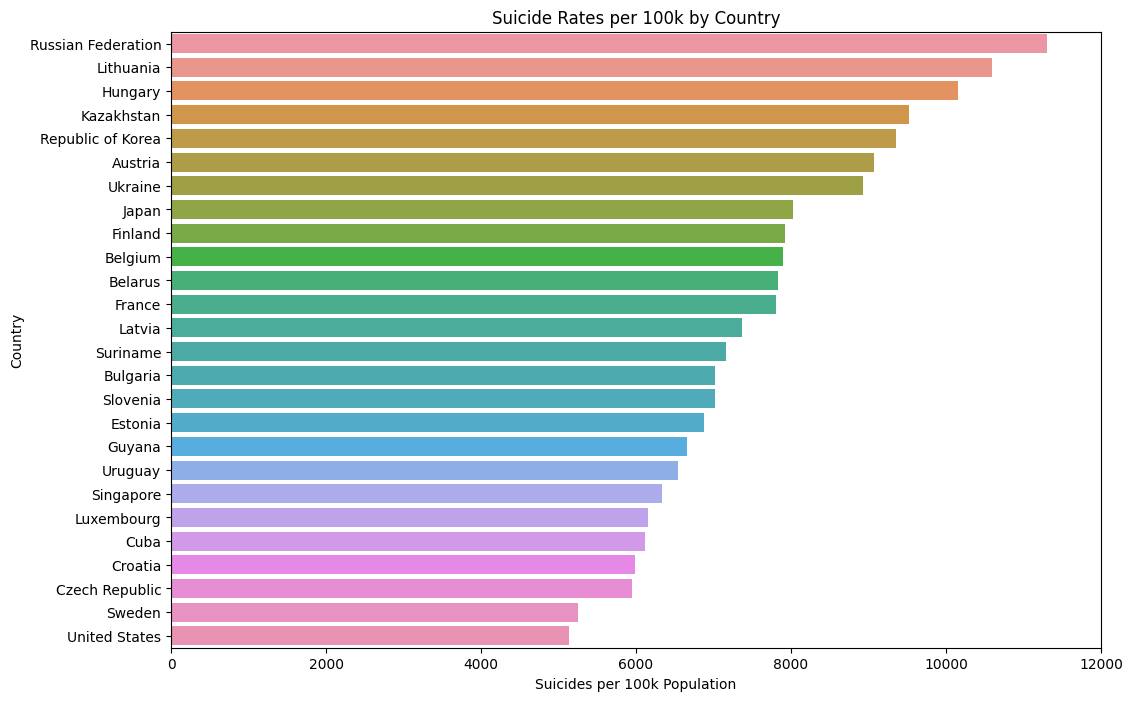

In [5]:
# Sort the DataFrame based on the total 'suicides_per_100k' by country in descending order
country_suicide_rate = suicide_data.groupby(by='country').sum().reset_index().sort_values(by='suicides/100k pop',ascending=False)

# Plot the top 25 countries for total suicide rate
plt.figure(figsize=(12, 8))
sns.barplot(x='suicides/100k pop', y='country', data=country_suicide_rate.iloc[:26, :])
plt.title('Suicide Rates per 100k by Country')
plt.xlim(0, 12000)
plt.xlabel('Suicides per 100k Population')
plt.ylabel('Country')
plt.show()

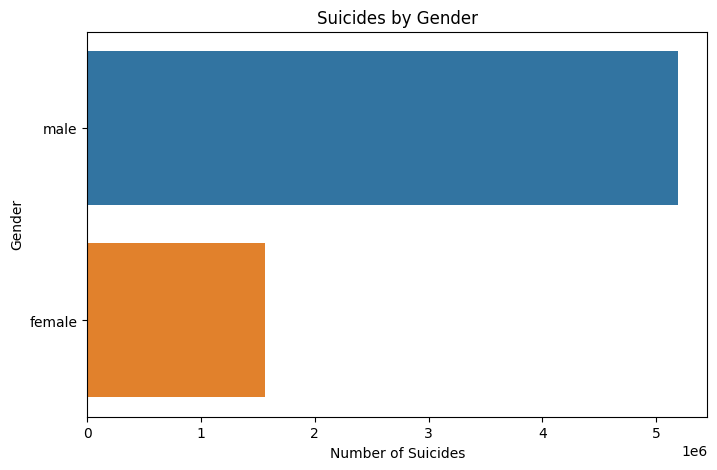

In [6]:
# plot suicides by gender
suicides_by_gender = suicide_data.groupby(by='sex').sum().reset_index().sort_values(by='suicides_no',ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='suicides_no', y='sex', data=suicides_by_gender)
plt.title('Suicides by Gender')
plt.xlabel('Number of Suicides')
plt.ylabel('Gender')
plt.show()

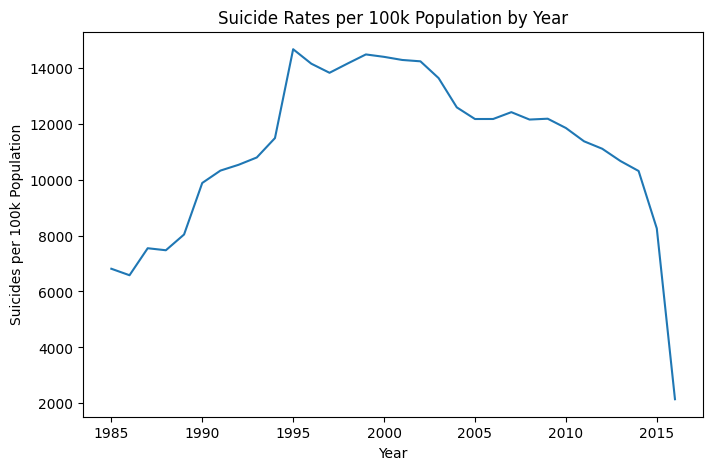

In [7]:
# plot suicide rate by year
suicides_by_year = suicide_data.groupby(by='year').sum().reset_index().sort_values(by='suicides/100k pop',ascending=False)
plt.figure(figsize=(8, 5))
sns.lineplot(x='year', y='suicides/100k pop', data=suicides_by_year)
plt.title('Suicide Rates per 100k Population by Year')
#plt.xlim(0, 12000)
plt.ylabel('Suicides per 100k Population')
plt.xlabel('Year')
plt.show()

In [8]:
# Check for null values
suicide_data.isnull().any()

country               False
year                  False
sex                   False
age                   False
suicides_no           False
population            False
suicides/100k pop     False
country-year          False
HDI for year           True
 gdp_for_year ($)     False
gdp_per_capita ($)    False
generation            False
dtype: bool

In [9]:
# Determine data types
suicide_data.dtypes

country                object
year                    int64
sex                    object
age                    object
suicides_no             int64
population              int64
suicides/100k pop     float64
country-year           object
HDI for year          float64
 gdp_for_year ($)      object
gdp_per_capita ($)      int64
generation             object
dtype: object

The most important information to learn from the suicide dataset is whether an observation has a high chance of suicide or a low chance of suicide. This information can be "machine learned" after applying some data preprocessing techniques and defining a threshold to distinguish between high and low suicide rates.  

Other questions that could be valuable to explore in this dataset are:
- Is the suicide rate higher among men or women?
- Which countries have the highest suicide rates? 
- Does GDP per capita influence a country's suicide rate?
- Is the suicide rate higher among older generations or younger generations?

The problem of predicting high vs. low suicide rates can be set up by applying some data preprocessing techniques to clean and explore the dataset. The preliminary analysis above shows that the data contains a redundant feature, "country/year," and some missing values for the "HDI for year" feature. The redundant feature can be removed, and the missing values can be imputed if the feature is significant. Feature selection and extraction techniques can identify the most significant features for this problem. Removing insignificant features that introduce noise can improve model performance. Applying an unsupervised approach, such as k-means clustering, can help identify patterns in the numerical variables. Supervised learning approaches, such as random forests, can provide more insight into feature importance. Feature extraction techniques can also be applied to determine if data dimensionality can be reduced while retaining important information. Principal component analysis can be used for unsupervised feature extraction. The following analysis compares model accuracy between feature selection and feature extraction techniques.

This problem can be structured as either a classification or regression problem. This analysis demonstrates the classification approach. The regression approach is demonstrated in a subsequent notebook. A decision tree classifier will be a good baseline model for this classification problem. These models are simple, interpretable, and can obtain good classification accuracy. More powerful techniques can be compared to the baseline model in later stages of development. This analysis compares a decision tree, random forest, and multilayer perceptron. The model evaluation stage will use startified 10-fold validation. False negatives should be penalized more than false positives for this problem. Therefore, model recall will be a valuable evaluation metric. The F1 score will also be used for model evaluation to show the balance between precision and recall. 

After selecting a model, hyperparameter tuning will be applied to see if the model can be optimized. The model can be retrained on the entire dataset after completing the evaluation stage.

The analysis in the subsequent section determines the threshold value that separates "high" and "low" suicide rates for this problem. Consulting a subject matter expert could provide a more accurate threshold value.

A feature derived from "Suicides/100k pop" will be the dependent variable for the suicide rate prediction problem. This variable can be transformed to binary output for a classification problem using binning. The variable will have two bins, "low suicide rate" and "high suicide rate." The cell below calculates some summary statistics to help identify a good threshold value to separate the categories.

Suicides/100k pop range: 0.0 - 224.97
Suicides/100k pop mean: 12.816097411933864
Suicides/100k pop median: 5.99


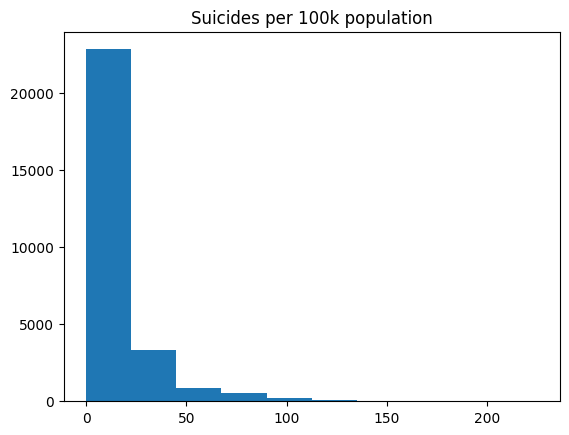

In [10]:
# Calculate summary statistics
min_val = suicide_data['suicides/100k pop'].min()
max_val = suicide_data['suicides/100k pop'].max()
mean = suicide_data['suicides/100k pop'].mean()
median = suicide_data['suicides/100k pop'].median()

# Display results and histogram
print(f"Suicides/100k pop range: {min_val} - {max_val}")
print(f"Suicides/100k pop mean: {mean}")
print(f"Suicides/100k pop median: {median}")
plt.hist(suicide_data["suicides/100k pop"])
plt.title("Suicides per 100k population")
plt.show()

Based on this analysis, the median value could be a good threshold to distinguish between high suicide rates and low suicide rates because the data has a strong right sku influencing the mean. This sku suggests that there is a small subset of examples with much higher suicide rates than others. The cell below transforms the dependent variable and removes the numerical version of this feature. It is important to remove the numerical version of the suicide rate feature so the model cannot use it to predict the chance of suicide. Leaving the original feature in the dataset would provide false evaluation results.

In [11]:
# Confirm that the dependent variable does not have null values
assert len(suicide_data[suicide_data['suicides/100k pop'].isnull()]) == 0

In [12]:
# Create bins using the median
bins = [min_val-1, median, max_val+1]

# Create labels for the bins
labels = ['low suicide rate', 'high suicide rate']

# Create a new feature using the bins and labels
suicide_data['suicide rate'] = pd.cut(suicide_data['suicides/100k pop'], bins=bins, labels=labels)

# Get num labels to confirm that no data was lost in the transformation
num_labels = suicide_data['suicides/100k pop'].count()

# drop the numerical version of suicide rate
new_suicide_data = suicide_data.drop('suicides/100k pop', axis=1)
one_hot_suicide_data = deepcopy(new_suicide_data)

# Confirm that no data was lost in the transformation
print(f"Number of labels before transformation: {num_labels}. Number of labels after tranformation {new_suicide_data['suicide rate'].count()}")

# convert the dependant variable to binary
new_suicide_data['suicide rate'] = new_suicide_data['suicide rate'].map({"low suicide rate": 0, "high suicide rate": 1}).astype(int)

# Visualize a subset of the new dataframe
new_suicide_data.head()

Number of labels before transformation: 27820. Number of labels after tranformation 27820


,country,year,sex,age,suicides_no,population,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation,suicide rate
0,Albania,1987,male,15-24 years,21,312900,Albania1987,NaN,"2,156,624,900",796,Generation X,1
1,Albania,1987,male,35-54 years,16,308000,Albania1987,NaN,"2,156,624,900",796,Silent,0
2,Albania,1987,female,15-24 years,14,289700,Albania1987,NaN,"2,156,624,900",796,Generation X,0
3,Albania,1987,male,75+ years,1,21800,Albania1987,NaN,"2,156,624,900",796,G.I. Generation,0
4,Albania,1987,male,25-34 years,9,274300,Albania1987,NaN,"2,156,624,900",796,Boomers,0


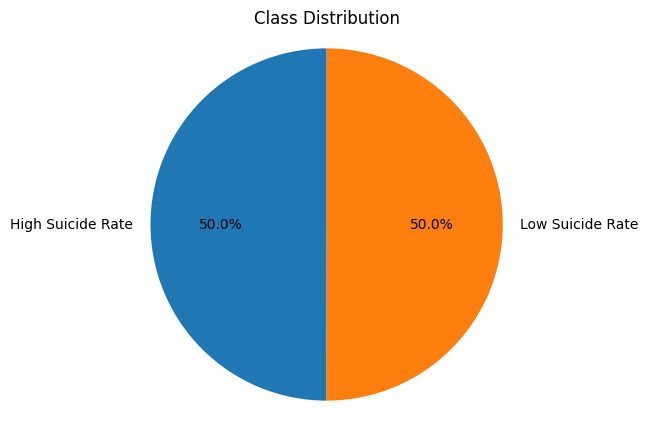

In [13]:
# plot the class distribution
fig = plt.figure(figsize=(5, 5))
labels = 'High Suicide Rate', 'Low Suicide Rate'
data_labels = new_suicide_data['suicide rate']

survivor_dist = [list(data_labels).count(1), list(data_labels).count(0)] 

plt.pie(survivor_dist, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  
plt.title('Class Distribution')
plt.show()

## Feature Exploration
The following section applies multiple techniques to feature exploration and ranking. The first approach uses the Pearson correlation matrix to see if any correlations exist between the suicide rate and the independent variables. The second approach uses k-means clustering to see if patterns exist in the data that can separate the classes. The third approach uses a random forest to determine feature importance. The final approach applies principal component analysis to determine if feature extraction could be more valuable with this dataset than feature selection.

These feature ranking and data exploration techniques require numerical variables. The `'generation'` feature is excluded from this analysis in favor of the `'age'` variable that contains similar information. The `'country-year'` and `'gdp per capita'` features are also excluded because they are duplicates of other features. The `'sex'` feature is one hot encoded with one column removed since it is a binary value. The `'suicide no'` feature is removed because this feature can be used with `'population'` to directly calculate the suicide rate. 

The country feature is encoded as a numerical variable using category codes because one hot encoding would make clustering and correlation techniques less interpretable. The random forest feature selection is tested with both the category version of the country variable and the one-hot encoded country variable to compare the results. The subsequent section uses one-hot encoding with the country variable before feeding the data to the machine learning models. It is better to use one hot encoding with nominal data so the model does not assume there is an ordinal relationship between values. As shown below, one-hot encoding could also have negative effects when using a random forest for feature selection. The principal component analysis test uses the one-hot encoded dataset to see if dimensionality can be reduced while retaining the information needed for predictions. 

<a id="general_preprocessing"></a>
### General Preprocessing

In [14]:
# one-hot encode gender and drop female column
new_suicide_df = pd.get_dummies(new_suicide_data, columns=['sex']).drop('sex_female', axis=1)

# drop generation, country-year, and gcp per capita
new_suicide_df.drop('generation', axis=1, inplace=True)
new_suicide_df.drop('gdp_per_capita ($)', axis=1, inplace=True)
new_suicide_df.drop('country-year', axis=1, inplace=True)

# drop number of suicides since this can be used with population to predict the suicide rate
new_suicide_df.drop('suicides_no', axis=1, inplace=True)

# rename columns
new_suicide_df.rename(columns={' gdp_for_year ($) ': 'gdp_for_year'}, inplace=True)
new_suicide_df.rename(columns={'HDI for year': 'hdi_for_year'}, inplace=True)
new_suicide_df.rename(columns={'suicide rate': 'suicide_rate'}, inplace=True)

# convert string numbers to numeric
new_suicide_df['gdp_for_year'] = new_suicide_df['gdp_for_year'].str.replace(',', '').astype('float64')

# fill missing values in HDI for year features
new_suicide_df['hdi_for_year'] = new_suicide_df['hdi_for_year'].fillna(new_suicide_df['hdi_for_year'].mean())

### Feature Ranking and Exploration Preprocessing

In [15]:
feature_exploration_df = deepcopy(new_suicide_df)

# convert the age variable to codes and retain original mapping
age_mapping = dict(enumerate(feature_exploration_df['age'].astype('category').cat.categories))
feature_exploration_df['age'] = feature_exploration_df['age'].astype('category').cat.codes

# convert country to category codes and retain original mapping
country_mapping = dict(enumerate(feature_exploration_df['country'].astype('category').cat.categories))
feature_exploration_df['country'] = feature_exploration_df['country'].astype('category').cat.codes

# convert all integers to floats
feature_exploration_df = feature_exploration_df.astype('float64')

# visualize new dataset
print("Feature Ranking Dataset")
feature_exploration_df.head()

Feature Ranking Dataset


,country,year,age,population,hdi_for_year,gdp_for_year,suicide_rate,sex_male
0,0.0,1987.0,0.0,312900.0,0.776601,2.156625e+09,1.0,1.0
1,0.0,1987.0,2.0,308000.0,0.776601,2.156625e+09,0.0,1.0
2,0.0,1987.0,0.0,289700.0,0.776601,2.156625e+09,0.0,0.0
3,0.0,1987.0,5.0,21800.0,0.776601,2.156625e+09,0.0,1.0
4,0.0,1987.0,1.0,274300.0,0.776601,2.156625e+09,0.0,1.0


#### Correlation Matrix

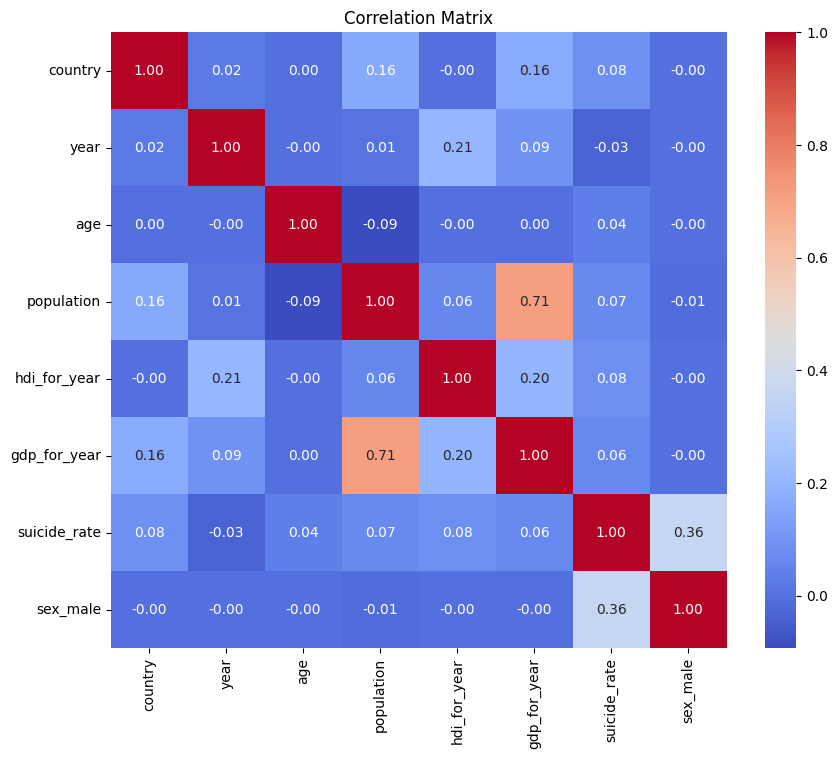

In [16]:
# get correlation matrix
corr = feature_exploration_df.corr()

# Generate a heatmap with Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)

# Add title
plt.title('Correlation Matrix')

# Show plot
plt.show()

The correlation matrix shows the highest correlation between sex_male and suicide_rate. The other features all show weaker correlations in this analysis.

#### K-Mean Clustering

The k-means clustering algorithm is tested with both scaled and unscaled data in the subsequent section. 

In [17]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import preprocessing

# Test clustering with scaled and unscaled data
km = KMeans(n_clusters=2, random_state=0, n_init=10)
k_means_df = feature_exploration_df.drop(['suicide_rate'], axis=1)
clusters = km.fit_predict(np.array(k_means_df))
accuracy = accuracy_score(feature_exploration_df['suicide_rate'], clusters)

print(f"Accuracy (Unscaled Data): {accuracy}")

scaled_df = deepcopy(k_means_df)
min_max_scaler = preprocessing.MinMaxScaler()
scaled_df = min_max_scaler.fit_transform(scaled_df[scaled_df.columns])
scaled_clusters = km.fit_predict(np.array(scaled_df))
accuracy = accuracy_score(feature_exploration_df['suicide_rate'], scaled_clusters)

print(f"Accuracy (Scaled Data): {accuracy}")

Accuracy (Unscaled Data): 0.5024442846872753
Accuracy (Scaled Data): 0.3186915887850467


The cluster accuracy is no higher than if the model made random guesses. Therefore, clustering does not provide much insight into class separation for the problem of predicting high vs. low suicide rates. The subsequent section applies a supervised approach to feature selection using a random forest.

#### Random Forest Feature Importance

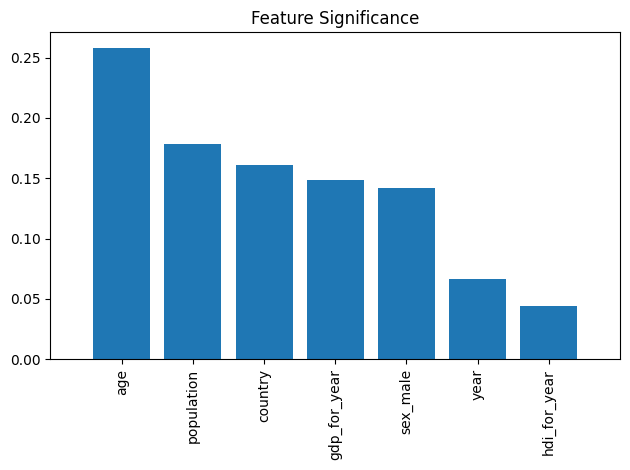

In [18]:
# get a 90/10 split for train and test data
forest_df = feature_exploration_df.drop('suicide_rate', axis=1)
x_train, x_test, y_train, y_test = train_test_split(forest_df, feature_exploration_df['suicide_rate'], test_size=0.1, shuffle=True, random_state=0)
features = forest_df.columns

# the following code is from Python Machine Learning, 3rd Edition, pg. 141
forest = RandomForestClassifier(n_estimators=500, random_state=1)
forest.fit(x_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

plt.title('Feature Significance')
plt.bar(range(x_train.shape[1]), importances[indices], align='center')
plt.xticks(range(x_train.shape[1]), features[indices], rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.tight_layout()

The random forest model determined that ['age', 'population', sex_male', 'country', 'gdp_per_year'] are the most import features in the dataset. The following section applies the same random forest model with the one hot encoded dataset for comparison. 

<a id="one_hot_encoding"></a>
#### One Hot Encoding (country, age)

In [19]:
feature_exploration_df2 = deepcopy(new_suicide_df)

# one hot encode age
feature_exploration_df2 = pd.get_dummies(feature_exploration_df2, columns=['age'])

# one hot encode country
feature_exploration_df2 = pd.get_dummies(feature_exploration_df2, columns=['country'])

# convert all integers to floats
feature_exploration_df2 = feature_exploration_df2.astype('float64')

# visualize new dataset
print("Feature Ranking Dataset 2 (one hot encoded)")
feature_exploration_df2.head()

Feature Ranking Dataset 2 (one hot encoded)


,year,population,hdi_for_year,gdp_for_year,suicide_rate,sex_male,age_15-24 years,age_25-34 years,age_35-54 years,age_5-14 years,...,country_Thailand,country_Trinidad and Tobago,country_Turkey,country_Turkmenistan,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan
0,1987.0,312900.0,0.776601,2.156625e+09,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1987.0,308000.0,0.776601,2.156625e+09,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1987.0,289700.0,0.776601,2.156625e+09,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1987.0,21800.0,0.776601,2.156625e+09,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1987.0,274300.0,0.776601,2.156625e+09,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


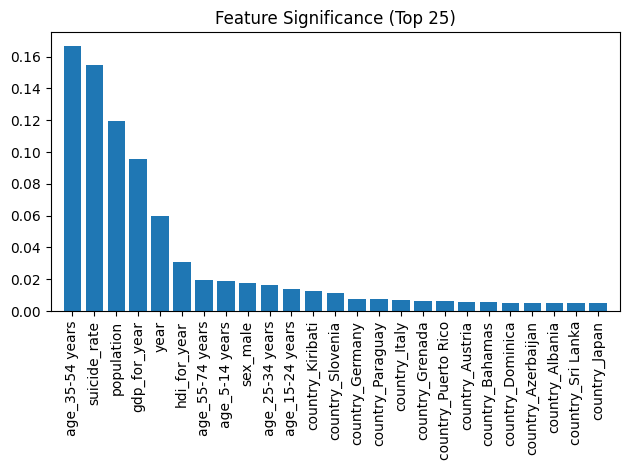

In [20]:
# get a 90/10 split for train and test data
exploration_df2_unlabeled = feature_exploration_df2.drop('suicide_rate', axis=1)
x_train, x_test, y_train, y_test = train_test_split(exploration_df2_unlabeled, feature_exploration_df2['suicide_rate'], test_size=0.1, shuffle=True, random_state=0)
features = feature_exploration_df2.columns

# the following code is from Python Machine Learning, 3rd Edition, pg. 141
forest = RandomForestClassifier(n_estimators=500, random_state=1)
forest.fit(x_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
indices = indices[:25]

plt.title('Feature Significance (Top 25)')
plt.bar(range(x_train.shape[1]-87), importances[indices], align='center')
plt.xticks(range(x_train.shape[1]-87), features[indices], rotation=90)
plt.xlim([-1, x_train.shape[1]-87])
plt.tight_layout()

The random forest produced different results for the feature importance between the one-hot encoded data and the category encoded data. The module reading mentioned that "if two features are highly correlated," one feature might be ranked high, and information in the other features could be missed (Raschka & Mirjalili, 2019). Since the one hot-encoded version of the country feature contains many highly correlated variables, I will use the information from the first analysis and treat the country as a significant feature.

### PCA

The final analysis applies PCA to determine if data extraction techniques could provide more value than feature selection techniques. 

In [21]:
scaler = StandardScaler()

# Use 113 components initially to find a good number of components to explain the majority of the variance in the dataset.
scaled_pca_data = scaler.fit_transform(exploration_df2_unlabeled)
pca = PCA(n_components=112).fit(scaled_pca_data)
pca_data = pca.transform(scaled_pca_data)

print(f"The first 10 principal components account for {round(100 * sum(pca.explained_variance_ratio_[:10]), 2)}% of the variance in the dataset.")
print(f"The first 25 principal components account for {round(100 * sum(pca.explained_variance_ratio_[:25]), 2)}% of the variance in the dataset.")
print(f"The first 50 principal components account for {round(100 * sum(pca.explained_variance_ratio_[:50]), 2)}% of the variance in the dataset.")
print(f"The first 75 principal components account for {round(100 * sum(pca.explained_variance_ratio_[:75]), 2)}% of the variance in the dataset.")
print(f"The first 100 principal components account for {round(100 * sum(pca.explained_variance_ratio_[:100]), 2)}% of the variance in the dataset.")
print(f"The first 105 principal components account for {round(100 * sum(pca.explained_variance_ratio_[:105]), 2)}% of the variance in the dataset.")

The first 10 principal components account for 12.22% of the variance in the dataset.
The first 25 principal components account for 25.79% of the variance in the dataset.
The first 50 principal components account for 48.4% of the variance in the dataset.
The first 75 principal components account for 70.96% of the variance in the dataset.
The first 100 principal components account for 93.41% of the variance in the dataset.
The first 105 principal components account for 97.88% of the variance in the dataset.


The results determined that we need about 105 of 113 principal components to account for more than 95% of the variance in the data. These results indicate that most (or all) of the remaining features in the dataset provide valuable information that could be lost in data reduction.  

In [22]:
# retain a pca df with the first 105 components to use for a comparison test below
pca = PCA(n_components=105).fit(scaled_pca_data)
pca_data = pca.transform(scaled_pca_data)

The previous section applied data preprocessing to prepare the data for the k-means clustering and random forest models. The following sections outline the data preprocessing steps applied to the current dataset.

**Preprocessing completed during [general_preprocessing](#general_preprocessing):**

-  Redundant features were removed from the dataset, including `'generation'`, `'gdp per capita'`, and `'country/year'`.
- The `'suicide no'` feature was removed from the dataset because it could be used with population to directly calculate the `'suicide_rate'`.
- The `'HDI for year'` feature had some missing values that were replaced with the feature mean.
- All feature names were updated to have similar naming conventions (ex: `'HDI for year'` -> `'hdi_for_year'`).
- The dependent variable was encoded with category codes to be a binary value of 0 for `'low suicide rate'` and 1 for `'high suicide rate'`.
- The `'sex'` variable was converted using one-hot encoding. The `'sex_female'` feature was dropeed since `'sex_male': 0` corresponds to `'sex_female'`.
- The `'gdp_for_year'` feature was converted from a string value to a `float64`.

**Preprocessing completed in the [one-hot-encoding section](#one_hot_encoding):**

- The `'age'` variable was converted to a numerical variable using one-hot encoding.
- The `'country'` feature was converted to a numerical variable using one-hot encoding.
- All dataset values were converted to `float64` data types. 

Year is the only remaining feature in the dataset that none of the above analyses classified as a significant feature. Year can be removed from the dataset. 

The final dataset contains the following features:
- Country (one-hot encoded as 101 different features)
- Age (One-hot encoded as 6 different features)
- sex_male
- gpd_per_capita
- gdp_for_year
- hdi_for_year
- population

In [23]:
# get the one-hot encoded dataframe from the feature exploration section
final_df = feature_exploration_df2

# drop year
final_df = final_df.drop('year', axis=1)
#one_hot_final_df = one_hot_final_df.drop('hdi_for_year', axis=1)

# Get labels and drop them from the data
final_labels = final_df['suicide_rate']
final_df.drop('suicide_rate', axis = 1, inplace=True)
final_df.head()

,population,hdi_for_year,gdp_for_year,sex_male,age_15-24 years,age_25-34 years,age_35-54 years,age_5-14 years,age_55-74 years,age_75+ years,...,country_Thailand,country_Trinidad and Tobago,country_Turkey,country_Turkmenistan,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan
0,312900.0,0.776601,2.156625e+09,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,308000.0,0.776601,2.156625e+09,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,289700.0,0.776601,2.156625e+09,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,21800.0,0.776601,2.156625e+09,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,274300.0,0.776601,2.156625e+09,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
final_df = np.array(final_df)

## Model Training

The classification problem is outlined above. The goal is to predict high vs. low suicide rates using the dependent variable, `'suicide_rate'`. This section explores different models to classify high and low suicide rates using the preprocessed dataset. A decision tree was tested as the baseline model. A random forest and multilayer perceptron were compared to the baseline model. The models are evaluated using 10-fold stratified cross-validation. The metrics calculated in the analysis are accuracy and recall. Recall is important for this problem because false negatives should be penalized more than false positives when predicting high and low suicide risks.

### Helpers

<a id="stratified_k_fold"></a>
### stratified_k_fold

*The stratified_k_fold function runs stratified 10_fold validation using the provided model function and parameters list. Stratified k-fold validation is valuable when the dependent variable is unbalanced. The function outputs the average accuracy (with standard deviation) and the average recall (with standard deviation). The function has optional scaled and scaler values to specify if the data should be scaled and set the desired scaler.*

* **data** np.array: a dataset 
* **labels** List[str]: a list of feature names for the dataframe columns and rows  
* **num_iter** int: number of iterations
* **model_function** Callable: a callable model function
* **params** List[Any]: a list of parameters to pass to the model function
* **scaled** bool: a boolean specifying if the data should be scaled
* **scaler** Callable: a callable scaler object to use for feature scaling

**returns** None

In [25]:
def stratified_k_fold(data: np.array, labels: List[str], num_iter: int, model_function: Callable, params:List[Any]=[], scaled:bool=False, scaler:Callable=None) -> None:
    train_f1s, train_recalls, test_f1s, test_recalls = [], [], [], []
    for i in range(num_iter):
        k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=i)
        for train_idx, test_idx in k_fold.split(data, labels):
            train_data = data[train_idx]
            test_data = data[test_idx]
            if scaled == True and scaler != None:
                # Scale data
                train_data = scaler.fit_transform(train_data)
                test_data = scaler.transform(test_data)
            # train and evaluate model
            train_f1, train_recall, test_f1, test_recall = model_function(train_data, test_data, labels[train_idx], labels[test_idx], params)
            # append accuracies and recalls to results
            train_f1s.append(train_f1)
            train_recalls.append(train_recall)
            test_f1s.append(test_f1)
            test_recalls.append(test_recall)

    print(f'Stratified 10-fold CV train F1 score={np.mean(train_f1s):.3f} {chr(177)}{np.std(train_f1s):.4f}, train recall={np.mean(train_recalls):.3f} {chr(177)}{np.std(train_recalls):.4f} with {num_iter} iterations')
    print(f'Stratified 10-fold CV test F1 score={np.mean(test_f1s):.3f} {chr(177)}{np.std(test_f1s):.4f}, test recall={np.mean(test_recalls):.3f} {chr(177)}{np.std(test_recalls):.4f} with {num_iter} iterations')

<a id="decision_tree"></a>
### decision_tree

*The decision_tree function trains and evaluates a decision tree using the provided training and test sets. The function returns the F1 score and recall for the training and test sets*

* **x_train** np.array: the training dataset
* **y_train** np.array: the training labels
* **x_test** np.array: the testing dataset
* **y_test** np.array: the testing labels
* **params** List[Any]: a list of parameters to pass to the model function

**returns** Tuple[List[float]]

In [26]:
def decision_tree(x_train: np.array, x_test: np.array, y_train: np.array, y_test: np.array, params: List[Any]) -> Tuple[List[float]]:
    decision_tree = tree.DecisionTreeClassifier()
    tree_model = decision_tree.fit(x_train, y_train)
    dt_train_predictions = tree_model.predict(x_train)
    dt_test_predictions = tree_model.predict(x_test)
    
    train_f1 = round(100 * f1_score(y_train, dt_train_predictions), 2)
    train_recall = round(100 * recall_score(y_train, dt_train_predictions), 2)
    test_f1 = round(100 * f1_score(y_test, dt_test_predictions), 2)
    test_recall = round(100 * recall_score(y_test, dt_test_predictions), 2)
       
    return train_f1, train_recall, test_f1, test_recall

<a id="random_forest"></a>
### random_forest

*The random_forest function trains and evaluates a random forest classifier using the provided training and test sets. The function returns the F1 score and recall for the training and test sets*

* **x_train** np.array: the training dataset
* **y_train** np.array: the training labels
* **x_test** np.array: the testing dataset
* **y_test** np.array: the testing labels
* **params** List[Any]: a list of parameters to pass to the model function

**returns** Tuple[List[float]]

In [27]:
def random_forest(x_train: np.array, x_test: np.array, y_train: np.array, y_test: np.array, params: List[Any]) -> Tuple[List[float]]:
    # Create a new random forest classifier, with working 4 parallel cores
    forest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0, n_jobs=4)
    # Train on training data
    forest.fit(x_train, y_train)
    # Test on training data
    train_predictions = forest.predict(x_train)
    test_predictions = forest.predict(x_test)
    
    train_f1 = round(100 * f1_score(y_train, train_predictions), 2)
    train_recall = round(100 * recall_score(y_train, train_predictions), 2)
    test_f1 = round(100 * f1_score(y_test, test_predictions), 2)
    test_recall = round(100 * recall_score(y_test, test_predictions), 2)
 
    # Return accuracy and recall
    return train_f1, train_recall, test_f1, test_recall

<a id="MLP"></a>
### MLP

*The MLP function trains and evaluates a multilayer perceptron using the provided training and test sets. The function returns the F1 score and recall for the training and test sets*

* **x_train** np.array: the training dataset
* **y_train** np.array: the training labels
* **x_test** np.array: the testing dataset
* **y_test** np.array: the testing labels
* **params** List[Any]: a list of parameters to pass to the model function

**returns** Tuple[List[float]]

In [28]:
def MLP(x_train: np.array, x_test: np.array, y_train: np.array, y_test: np.array, params: List[Any]) -> Tuple[List[float]]:
    # Set some default parameters
    hidden_layers_param = (10,)
    max_iter_param = 5000
    
    # get custom params
    if len(params) == 1:
        hidden_layers_param = params[0]
    if len(params) == 2:
        max_iter_param = params[1]
        
    mlp = MLPClassifier(random_state=1, max_iter=max_iter_param, solver='lbfgs', hidden_layer_sizes=hidden_layers_param)
    mlp.fit(x_train, y_train)
    train_predictions = mlp.predict(x_train)
    test_predictions = mlp.predict(x_test)
    train_f1 = round(100 * f1_score(y_train, train_predictions), 2)
    train_recall = round(100 * recall_score(y_train, train_predictions), 2)
    test_f1 = round(100 * f1_score(y_test, test_predictions), 2)
    test_recall = round(100 * recall_score(y_test, test_predictions), 2)
    
    return train_f1, train_recall, test_f1, test_recall

### Model Selection

#### Decision Tree

In [29]:
stratified_k_fold(final_df, final_labels, 10, decision_tree)

Stratified 10-fold CV train F1 score=100.000 ±0.0000, train recall=100.000 ±0.0000 with 10 iterations
Stratified 10-fold CV test F1 score=91.474 ±0.5534, test recall=91.435 ±0.7604 with 10 iterations


#### Random Forest

In [30]:
stratified_k_fold(final_df, final_labels, 10, random_forest)

Stratified 10-fold CV train F1 score=83.771 ±0.2789, train recall=87.653 ±0.7441 with 10 iterations
Stratified 10-fold CV test F1 score=83.483 ±0.7872, test recall=87.388 ±1.1951 with 10 iterations


#### Multilayer Perceptron

In [31]:
scaler = StandardScaler()
stratified_k_fold(final_df, final_labels, 10, MLP, [], True, scaler)

Stratified 10-fold CV train F1 score=92.992 ±0.1195, train recall=92.546 ±0.2196 with 10 iterations
Stratified 10-fold CV test F1 score=92.208 ±0.5429, test recall=91.761 ±0.8000 with 10 iterations


The analysis above determined that the multilayer perceptron was the best model for this classification problem. Hyperparameter tuning could increase model performance. The decision tree obtained comparable performance to the multilayer perceptron. However, the results of the random forest indicate that the single decision tree could be overfitting.

**References**

1. Raschka, S. & Mirjalili, V. (2019). Python Machine Learning Ed. 3. Packt Publishing.

 

